In [1]:
#import tools for web scraping:
from requests import get
from bs4 import BeautifulSoup
import os
import pandas as pd

#group imports
import env
import acquire
import constants_prepare

import json
from typing import Dict, List, Optional, Union, cast
import requests

#visualizations:
import matplotlib.pyplot as plt
import seaborn as sns

_____________________________________________________________________________

## Exploring Ubuntu:

In [2]:
ubuntu = pd.read_json('ubuntu_data.json')

In [3]:
ubuntu.head()

,repo,language,readme_contents
0,dockerfile/ubuntu,Shell,## Ubuntu Dockerfile\n\n\nThis repository cont...
1,boxcutter/ubuntu,Shell,# Packer templates for Ubuntu written in legac...
2,wszqkzqk/deepin-wine-ubuntu,C,# Deepin wine for Ubuntu and Debian\n\n## 一、项目...
3,fcwu/docker-ubuntu-vnc-desktop,HTML,# docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...
4,docker-32bit/ubuntu,Shell,ubuntu\n======\n\nBuild a docker image for ubu...


#### Normalizing the data:

In [4]:
import unicodedata
import re

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

In [5]:
#to view just one of the readme docs and see what kind of normalizing is needed:
soup = BeautifulSoup(ubuntu.readme_contents.iloc[10], 'html.parser')
soup

Ubuntu 18.04 CIS STIG

[![Build Status](https://travis-ci.com/florianutz/Ubuntu1804-CIS.svg?branch=master)](https://travis-ci.com/florianutz/Ubuntu1804-CIS)
[![Ansible Role](https://img.shields.io/badge/role-florianutz.Ubuntu1804--CIS-blue.svg)](https://galaxy.ansible.com/florianutz/Ubuntu1804-CIS/)

Configure Ubuntu 18.04 machine to be CIS compliant. Level 1 and 2 findings will be corrected by default.

This role **will make changes to the system** that could break things. This is not an auditing tool but rather a remediation tool to be used after an audit has been conducted.

## IMPORTANT INSTALL STEP

If you want to install this via the `ansible-galaxy` command you'll need to run it like this:

`ansible-galaxy install -p roles -r requirements.yml`

With this in the file requirements.yml:

```
- src: https://github.com/florianutz/Ubuntu1804-CIS.git
```

Based on [CIS Ubuntu Benchmark v2.0.1 - 01-03-2020 ](https://www.cisecurity.org/cis-benchmarks/).

This repo originated from work do

In [6]:
#getting an overall view of the data:
ubuntu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1100 non-null   object
 1   language         964 non-null    object
 2   readme_contents  1100 non-null   object
dtypes: object(3)
memory usage: 25.9+ KB


In [7]:
#looking at any nulls:
ubuntu.isnull().sum()

repo                 0
language           136
readme_contents      0
dtype: int64

In [8]:
#dropping nulls (we found that these repos have no languages attached)
ubuntu = ubuntu.dropna()

In [9]:
#df w/o nulls:
ubuntu.isnull().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [10]:
#seeing the unique languages:
ubuntu.language.value_counts()

Shell               502
Python              105
Dockerfile           51
C                    44
C++                  34
HTML                 33
Ruby                 27
JavaScript           24
Jinja                18
Go                   12
PHP                  12
CSS                  11
Makefile             11
Puppet               10
HCL                   9
Jupyter Notebook      8
Vim script            6
Dart                  6
PowerShell            4
QML                   4
Nginx                 3
Perl                  3
Objective-C           3
Scheme                2
C#                    2
TeX                   2
SCSS                  2
Haskell               2
R                     2
M4                    1
YAML                  1
Rich Text Format      1
Vue                   1
Java                  1
Scala                 1
Smarty                1
Groovy                1
VimL                  1
Emacs Lisp            1
Tcl                   1
Batchfile             1
Name: language, 

______________________________________________

## Ubuntu Languages:

In [11]:
#looking at the overall percentages of the top 10 languages used in Ubuntu repos:
language_counts=ubuntu.language.value_counts(normalize=True).head(10)
language_counts

Shell         0.520747
Python        0.108921
Dockerfile    0.052905
C             0.045643
C++           0.035270
HTML          0.034232
Ruby          0.028008
JavaScript    0.024896
Jinja         0.018672
Go            0.012448
Name: language, dtype: float64

In [12]:
#creating a df of the percentages to prep for charts:
temp = pd.DataFrame({'language' : language_counts.index, 'percentage': language_counts.values})
temp

,language,percentage
0,Shell,0.520747
1,Python,0.108921
2,Dockerfile,0.052905
3,C,0.045643
4,C++,0.035270
5,HTML,0.034232
6,Ruby,0.028008
7,JavaScript,0.024896
8,Jinja,0.018672
9,Go,0.012448


<AxesSubplot:xlabel='language', ylabel='percentage'>

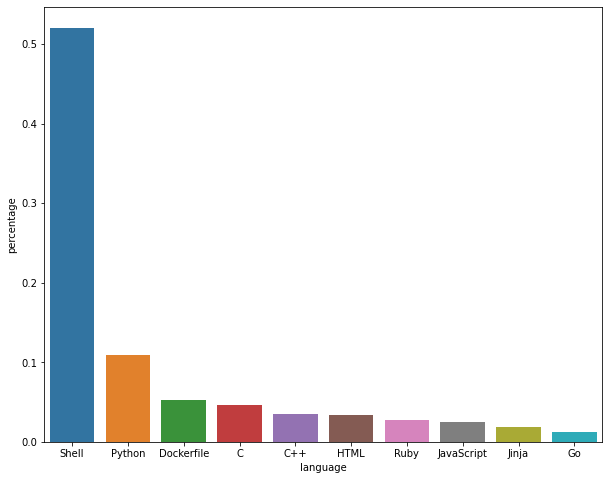

In [13]:
#plotting out the percentages of the Top 10 languages used in Ubuntu repos:
plt.figure(figsize=(10,8))
sns.barplot(data=temp, x = 'language', y = 'percentage')

## Cleaning the Data:

Steps to parsing data:
- 1) Convert text to all lower case for normalcy.
- 2) Remove any accented characters, non-ASCII characters.
- 3) Remove special characters and html and linux related words.
- 4) Stem or lemmatize the words.(stem = "if b, then c")
- 5) Remove stopwords.(if, and, the, etc)
- 6) Store the clean text and the original text for use in future notebooks.

In [14]:
ADDITIONAL_STOPWORDS = [
    'sudo',
    'distro',
    'linux',
    'aptget',
    'ubuntu',
    'debian',
    'arch',
    'archlinux',
    'git',
    'root',
    'image',
    'install',
    'installed',
    'installing',
    'use', 
    'user',
    'used',
    'using',
    'server',
    'kernel',
    'update',
    'package', 
    'file',
    'run', 
    'system', 
    'configure',
    'configured',
    'command',
    'script', 
    'set', 
    'build',
    'need',
    'make',
    'option',
    'contain',
    'contained',
    1,
    'server',
    'update',
    'updated',
    'kerneled',
    'version',
    '1',
    'download',
    'create', 
    'default'
    
] 

def clean_data(text):
    ps = nltk.porter.PorterStemmer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[\(<\"]?http.*[\)>\"\s]', ' ', text).split()
    words = [re.sub(r'[^\w\s]', '', text) for text in words]
    try:
        while True:
            words.remove('')
    except ValueError:
        pass
    
    return ' '.join([ps.stem(word) for word in words if word not in stopwords])

In [15]:
#grabbing text from df:
ubuntu_corpus = ' '.join(ubuntu['readme_contents'])
ubuntu_corpus[:100]

'## Ubuntu Dockerfile\n\n\nThis repository contains **Dockerfile** of [Ubuntu](http://www.ubuntu.com/) f'

In [16]:
#creating a list 
ubuntu_corpus_list = clean_data(ubuntu_corpus).split()
ubuntu_corpus_list

['dockerfil',
 'repositori',
 'contain',
 'dockerfil',
 'base',
 'docker',
 'ubuntu1404',
 'instal',
 'docker',
 '2',
 'autom',
 'altern',
 'dockerfil',
 'docker',
 'tdockerfileubuntu',
 'githubcomdockerfileubuntu',
 'usag',
 'docker',
 'rm',
 'dockerfileubuntu',
 'packer',
 'templat',
 'written',
 'legaci',
 'json',
 'overview',
 'repositori',
 'contain',
 'packer',
 'current',
 'box',
 'longer',
 'provid',
 'prebuilt',
 'binari',
 'templat',
 'build',
 'vagrant',
 'box',
 'packer',
 'box',
 'virtualbox',
 'vmware',
 'fusion',
 'parallel',
 'parallel',
 'requir',
 'parallel',
 'virtual',
 'sdk',
 'mac',
 'addit',
 'prerequisit',
 'json',
 'file',
 'contain',
 'variabl',
 'specif',
 'version',
 'tell',
 'packer',
 'specif',
 'variabl',
 'via',
 'varfil',
 'line',
 'overrid',
 'option',
 'core',
 'ubuntujson',
 'packer',
 'templat',
 'build',
 '2004',
 'exampl',
 '2004',
 'follow',
 'packer',
 'varfileubuntu2004json',
 'ubuntujson',
 'want',
 'box',
 'specif',
 'desktop',
 'virtual',
 '

In [17]:
u_count = pd.Series(ubuntu_corpus_list)

In [18]:
u_count.value_counts().nlargest(20)

docker      1763
bash        1473
instal      1316
e           1283
de          1246
contain     1129
ensur       1107
work        1102
follow      1067
chang       1052
2           1031
autom       1029
support      998
configur     956
start        952
test         943
file         931
run          930
name         901
gener        893
dtype: int64

In [19]:
#adding the clean function through the readme content and adding 
#onto a new column in the df:
ubuntu['clean_readme'] = ubuntu.readme_contents.apply(clean_data)
ubuntu

,repo,language,readme_contents,clean_readme
0,dockerfile/ubuntu,Shell,## Ubuntu Dockerfile\n\n\nThis repository cont...,dockerfil repositori contain dockerfil base do...
1,boxcutter/ubuntu,Shell,# Packer templates for Ubuntu written in legac...,packer templat written legaci json overview re...
2,wszqkzqk/deepin-wine-ubuntu,C,# Deepin wine for Ubuntu and Debian\n\n## 一、项目...,deepin wine deepinwin ubuntudebian deepin gite...
3,fcwu/docker-ubuntu-vnc-desktop,HTML,# docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...,dockerubuntuvncdesktop docker pull docker star...
4,docker-32bit/ubuntu,Shell,ubuntu\n======\n\nBuild a docker image for ubu...,docker i386 buildimagesh docker 32bitubuntu160...
...,...,...,...,...
1095,kurniawandata/nasihosting,PHP,# nasihosting\n\nNasihosting v5.2\n-----------...,nasihost nasihost v52 alt text untuk mendukung...
1096,mastermindg/trac-docker-ubuntu,Shell,# trac-ubuntu\n\n[![](https://images.microbadg...,tracubuntu docker hub repo build docker contai...
1097,hortonworks/docker-protractor,Shell,**General Docker image for executing headless ...,gener docker execut headless googl chrome fire...
1098,rubiojr/surface3-kernel,C,Linux kernel release 3.x <http://kerne...,releas 3x releas note 3 read care tell explain...


______________________________

## Creating a df for the top 10 languages:

In [20]:
#finding all shell readmes:
shell_readme =' '.join(ubuntu[ubuntu['language'] == 'Shell'].clean_readme)

In [21]:
ubuntu[ubuntu['language'] == 'Shell'].clean_readme

0       dockerfil repositori contain dockerfil base do...
1       packer templat written legaci json overview re...
4       docker i386 buildimagesh docker 32bitubuntu160...
6       termuxubuntu chroot termux wget proot termux p...
8       shadowsock auto shadowsock shadowsockssh auto ...
                              ...                        
1091    debianubuntu loung href altbuild statu src rep...
1093    minecraftinitscript jami bainbridg jamiebainbr...
1094    wsl dotfil simpl dotfil script setup _window s...
1096    tracubuntu docker hub repo build docker contai...
1097    gener docker execut headless googl chrome fire...
Name: clean_readme, Length: 502, dtype: object

In [22]:
#renaming to shell words and cleaning data:
shell_words=clean_data(shell_readme)

In [23]:
#finding all python readmes:
python_readme =' '.join(ubuntu[ubuntu['language'] == 'Python'].clean_readme)

In [24]:
#renaming to python words and cleaning data:
python_words=clean_data(python_readme)

In [25]:
#finding all dockerfile readmes:
dockerfile_readme =' '.join(ubuntu[ubuntu['language'] == 'Dockerfile'].clean_readme)

In [26]:
#renaming to dockerfile words and cleaning data:
dockerfile_words=clean_data(dockerfile_readme)

In [27]:
#finding all C readmes:
C_readme =' '.join(ubuntu[ubuntu['language'] == 'C'].clean_readme)

In [28]:
#renaming to C words and cleaning data:
C_words=clean_data(C_readme)

In [29]:
#finding all C ++ readmes:
Cplus_readme =' '.join(ubuntu[ubuntu['language'] == 'C++'].clean_readme)

In [30]:
#renaming to C++ words and cleaning data:
Cplus_words=clean_data(Cplus_readme)

### Finding word frequencies per language:

In [31]:
#creating series with frequencies by putting the clean_readme strings
#as series (but use split to split up words into a list)

shell_freq = pd.Series(shell_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
dockerfile_freq = pd.Series(dockerfile_words.split()).value_counts()
C_freq = pd.Series(C_words.split()).value_counts()
Cplus_freq = pd.Series(Cplus_words.split()).value_counts()

In [32]:
#looking at how we need to split:
pd.Series(shell_words.split()).value_counts()

de               1227
e                1059
bash              794
video             773
instal            734
                 ... 
xlm                 1
tether              1
usdt                1
bch                 1
ubuntuservers       1
Length: 22346, dtype: int64

In [33]:
#combining frequencies into dataframes:
word_counts = (pd.concat([shell_freq, python_freq, dockerfile_freq, C_freq, Cplus_freq], axis=1, sort=True)
              .set_axis(['shell','python','dockerfile','C','Cplus'], axis=1, inplace=False)
              .fillna(0)
              .apply(lambda s: s.astype(int)))

In [34]:
word_counts.head()

,shell,python,dockerfile,C,Cplus
0,206,66,10,5,28
00,2,0,0,0,2
000,0,1,0,0,0
0000,5,0,1,0,0
00000,2,0,0,0,0


### What are the most occuring words across these languages?

In [35]:
word_counts.sort_values(by='shell', ascending=False).head(10)

,shell,python,dockerfile,C,Cplus
de,1227,2,0,0,4
e,1059,25,39,2,5
bash,794,96,67,32,23
video,773,2,3,5,1
instal,734,106,14,51,30
docker,671,82,471,11,0
work,577,137,45,38,47
follow,514,115,82,23,46
lt,498,16,28,9,23
link,467,24,14,7,5


___________________________________

## How long is a typical Ubuntu Readme (after clean)?

In [36]:
#creating a column that gives the lenght of the readme_contents after clean_data function
ubuntu['length_of_readme'] = ubuntu['readme_contents'].apply(lambda r : len(clean_data(r)))

<AxesSubplot:>

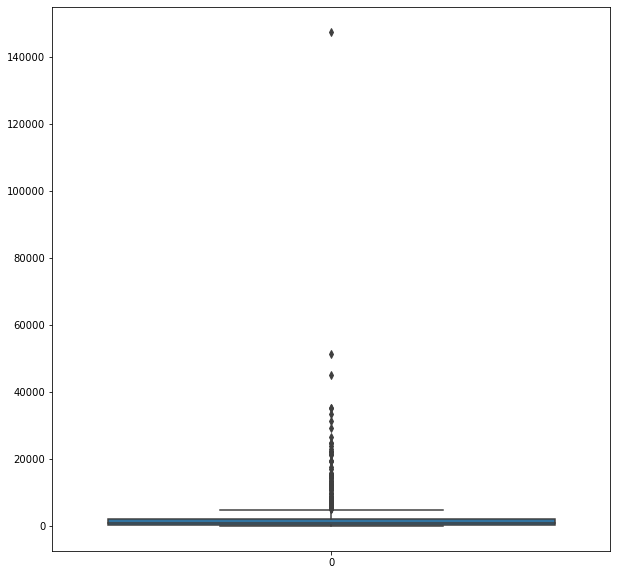

In [37]:
#plotting this to show any anomalies:
plt.figure(figsize = (10,10))
sns.boxplot(data = ubuntu.length_of_readme)

In [38]:
#finding the mean, min and max of Ubuntu readmes:
ubuntu.length_of_readme.describe()

count       964.00000
mean       2532.25000
std        6611.96954
min           0.00000
25%         350.50000
50%        1006.00000
75%        2239.00000
max      147543.00000
Name: length_of_readme, dtype: float64

In [39]:
#longest readme info:
ubuntu[ubuntu['length_of_readme'] == 147543]

,repo,language,readme_contents,clean_readme,length_of_readme
1062,shaohua0116/ICLR2020-OpenReviewData,Jupyter Notebook,# Crawl and Visualize ICLR 2020 OpenReview Dat...,crawl visual iclr 2020 openreview data p align...,147543


In [40]:
#minimum readmes:
ubuntu[ubuntu['length_of_readme'] == 0]

,repo,language,readme_contents,clean_readme,length_of_readme
35,ErickWendel/ew-ubuntu-setup,Shell,,,0
74,officialputuid/UbuntuSSH,Shell,,,0
135,ErickWendel/ew-ubuntu-setup,Shell,,,0
174,officialputuid/UbuntuSSH,Shell,,,0
263,till/ubuntu,Shell,,,0
284,Sushrut1101/Ubuntu-Tmate,Shell,,,0
303,sandheepgr/ubuntu-customization,Shell,,,0
454,umangv/indicator-stickynotes,Python,,,0
621,lxc/lxc-pkg-ubuntu,C,,,0
735,ubuntu-mate/ubuntu-mate-artwork,Shell,,,0


In [41]:
ubuntu['cleaned_length'] = 0

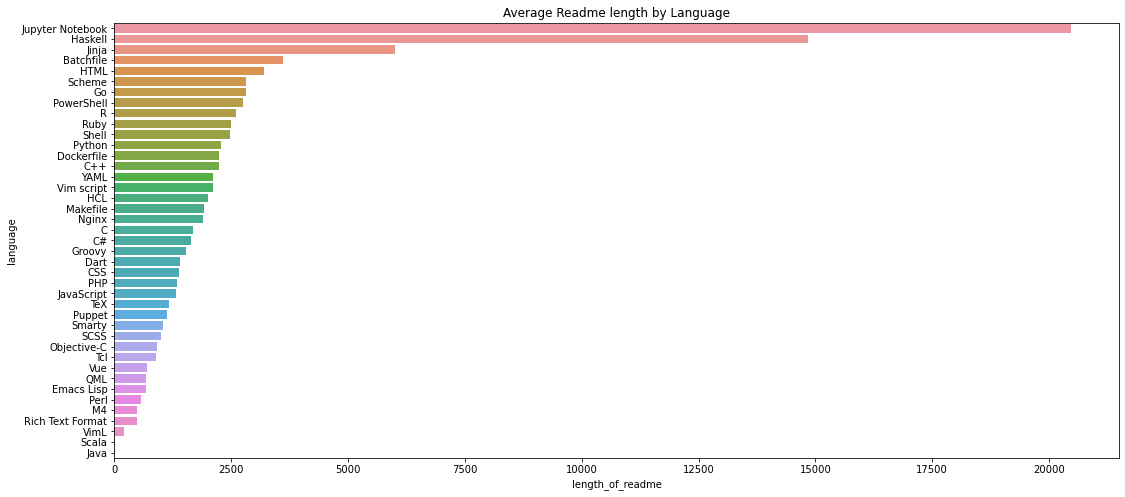

In [42]:
plt.figure(figsize=(18, 8))
sns.barplot(data = ubuntu.groupby('language').mean().reset_index().sort_values('length_of_readme', ascending=False), x = 'length_of_readme', y='language')
plt.title('Average Readme length by Language')
plt.show()

_____________________________________________

## Number of unique words in Ubuntu Repos:

In [43]:
ubuntu_corpus_series = pd.Series(ubuntu_corpus_list)
pd.Series(ubuntu_corpus_list).nunique()

43230

___________________________________________

## Most common bigrams of Ubuntu:

In [44]:
ubuntu_bigrams = (pd.Series(nltk.ngrams(ubuntu_corpus_series, 2)).value_counts().head(20))

In [45]:
ubuntu_bigrams

(math, librari)               322
(intelr, math)                320
(neural, network)             310
(tr, tr)                      249
(link, da)                    226
(video, aula)                 224
(da, video)                   222
(ness, video)                 220
(tdtd, aligncentersupport)    219
(environ, variabl)            193
(aligncentersupport, tdtd)    187
(librari, 2017)               183
(de, configuracao)            162
(2004x, lt)                   156
(reinforc, learn)             149
(tdtd, aligncenternot)        145
(aligncenternot, support)     145
(librari, 2018)               137
(de, 2004x)                   136
(gnulinux, 1804x)             130
dtype: int64

## Most common trigrams of Ubuntu:

In [46]:
ubuntu_trigrams = (pd.Series(nltk.ngrams(ubuntu_corpus_series, 3)).value_counts().head(20))
ubuntu_trigrams

(intelr, math, librari)                           320
(da, video, aula)                                 222
(link, da, video)                                 222
(math, librari, 2017)                             183
(tdtd, aligncentersupport, tdtd)                  168
(tdtd, aligncenternot, support)                   145
(math, librari, 2018)                             137
(de, 2004x, lt)                                   136
(aligncenternot, support, tdtd)                   129
(gnulinux, 1804x, lt)                             128
(2004x, lt, devop)                                122
(lt, devop, shell)                                118
(curso, gratuito, de)                             116
(shell, ness, video)                              116
(ness, video, vou)                                116
(devop, shell, ness)                              116
(gratuito, de, 2004x)                             116
(aligncentersupport, tdtd, aligncentersupport)    112
(utilizado, ness, video)    

________________________________________________

## Reading in the master list csv:

In [47]:
master_df = pd.read_csv('master_list.csv')

In [48]:
master_df

,repo,language,readme_contents
0,dockerfile/ubuntu,Shell,## Ubuntu Dockerfile\n\n\nThis repository cont...
1,boxcutter/ubuntu,Shell,# Packer templates for Ubuntu written in legac...
2,wszqkzqk/deepin-wine-ubuntu,C,# Deepin wine for Ubuntu and Debian\n\n## 一、项目...
3,fcwu/docker-ubuntu-vnc-desktop,HTML,# docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...
4,docker-32bit/ubuntu,Shell,ubuntu\n======\n\nBuild a docker image for ubu...
...,...,...,...
3295,gmas/home-router-ansible,Ruby,# home-router-ansible\nAnsible scripts for set...
3296,Voltasalt/tial,Shell,# tial\nTwitch Installs Arch Linux: Scripts\n
3297,Caesim404/sikulix-git,Shell,NaN
3298,danboid/ZALARM-install,NaN,# Installing Arch Linux ARM (ALARM) on the SHA...


### Exploring the data:

In [49]:
master_df.info

<bound method DataFrame.info of                                 repo language  \
0                  dockerfile/ubuntu    Shell   
1                   boxcutter/ubuntu    Shell   
2        wszqkzqk/deepin-wine-ubuntu        C   
3     fcwu/docker-ubuntu-vnc-desktop     HTML   
4                docker-32bit/ubuntu    Shell   
...                              ...      ...   
3295        gmas/home-router-ansible     Ruby   
3296                  Voltasalt/tial    Shell   
3297           Caesim404/sikulix-git    Shell   
3298          danboid/ZALARM-install      NaN   
3299               BiteDasher/pacadd    Shell   

                                        readme_contents  
0     ## Ubuntu Dockerfile\n\n\nThis repository cont...  
1     # Packer templates for Ubuntu written in legac...  
2     # Deepin wine for Ubuntu and Debian\n\n## 一、项目...  
3     # docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...  
4     ubuntu\n======\n\nBuild a docker image for ubu...  
...                            

In [50]:
master_df.describe()

,repo,language,readme_contents
count,3300,2936,3148
unique,2896,61,2742
top,angristan/openvpn-install,Shell,# openvpn-install\n\n![Test](https://github.co...
freq,6,1679,6


In [51]:
#any nulls?
master_df.isnull().sum()

repo                 0
language           364
readme_contents    152
dtype: int64

In [52]:
#dropping nulls:
master_df = master_df.dropna()

In [53]:
#just checking if worked:
master_df.isnull().sum()

repo               0
language           0
readme_contents    0
dtype: int64

## Looking at top languages across master_list:

In [54]:
#looking at the overall percentages of the top 10 languages used in all repos:
master_language_counts=master_df.language.value_counts(normalize=True).head(10)
master_language_counts

Shell         0.569697
Python        0.103030
C             0.050267
Dockerfile    0.035294
C++           0.022460
HTML          0.021034
JavaScript    0.018895
Makefile      0.018538
CSS           0.017112
Ruby          0.017112
Name: language, dtype: float64

In [55]:
#creating a df of the percentages to prep for charts:
temp = pd.DataFrame({'language' : master_language_counts.index, 'percentage': master_language_counts.values})
temp

,language,percentage
0,Shell,0.569697
1,Python,0.103030
2,C,0.050267
3,Dockerfile,0.035294
4,C++,0.022460
5,HTML,0.021034
6,JavaScript,0.018895
7,Makefile,0.018538
8,CSS,0.017112
9,Ruby,0.017112


<AxesSubplot:xlabel='language', ylabel='percentage'>

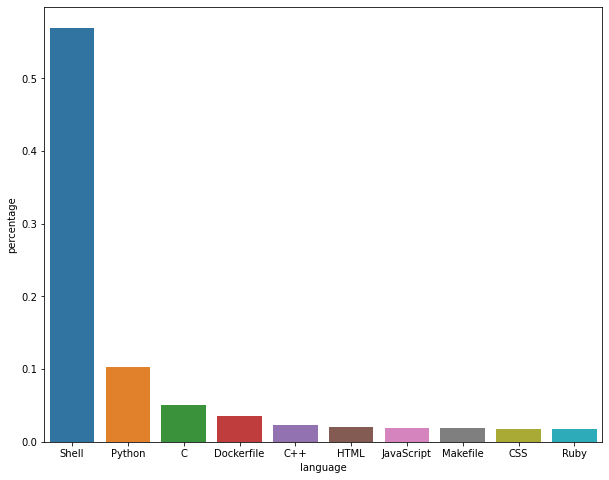

In [56]:
#plotting out the percentages of the Top 10 languages used in Ubuntu repos:
plt.figure(figsize=(10,8))
sns.barplot(data=temp, x = 'language', y = 'percentage')

## Finding common words overall for stop_words:

In [57]:
#grabbing text from df:
master_corpus = ' '.join(master_df['readme_contents'])
master_corpus[:100]

'## Ubuntu Dockerfile\n\n\nThis repository contains **Dockerfile** of [Ubuntu](http://www.ubuntu.com/) f'

In [58]:
#first, lower all letters:
master_corpus = master_corpus.lower()

In [59]:
#next, normalize by removing special characters:
import unicodedata

master_corpus = unicodedata.normalize('NFKD', master_corpus)\
    .encode('ascii', 'ignore')\
    .decode('utf-8', 'ignore')

In [60]:
#taking out special characters:
# remove anything that is not a through z, a number, a single quote, or whitespace
master_corpus = re.sub(r"[^a-z0-9'\s]", '', master_corpus)

In [61]:
#tokenizing:
import nltk
tokenizer = nltk.tokenize.ToktokTokenizer()

print(tokenizer.tokenize(master_corpus, return_str=True)[0:500])


ubuntu dockerfile


this repository contains dockerfile of ubuntuhttpwwwubuntucom for dockerhttpswwwdockercom ' s automated buildhttpsregistryhubdockercomudockerfileubuntu published to the public docker hub registryhttpsregistryhubdockercom


 base docker image

 ubuntu1404httpsregistryhubdockercomulibraryubuntu


 installation

1 install dockerhttpswwwdockercom

2 download automated buildhttpsregistryhubdockercomudockerfileubuntu from public docker hub registryhttpsregistryhubdockercom docker p


In [62]:
#removing main stopwords:
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')

stopword_list.remove('no')
stopword_list.remove('not')

stopword_list[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [63]:
#creating loop for this:
words = master_corpus.split()
filtered_words = [w for w in words if w not in stopword_list]

print('Removed {} stopwords'.format(len(words) - len(filtered_words)))
print('---')

corpus_without_stopwords = ' '.join(filtered_words)

print(corpus_without_stopwords)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [64]:
#creating a list 
master_corpus_list = corpus_without_stopwords.split()
master_corpus_list

['ubuntu',
 'dockerfile',
 'repository',
 'contains',
 'dockerfile',
 'ubuntuhttpwwwubuntucom',
 "dockerhttpswwwdockercom's",
 'automated',
 'buildhttpsregistryhubdockercomudockerfileubuntu',
 'published',
 'public',
 'docker',
 'hub',
 'registryhttpsregistryhubdockercom',
 'base',
 'docker',
 'image',
 'ubuntu1404httpsregistryhubdockercomulibraryubuntu',
 'installation',
 '1',
 'install',
 'dockerhttpswwwdockercom',
 '2',
 'download',
 'automated',
 'buildhttpsregistryhubdockercomudockerfileubuntu',
 'public',
 'docker',
 'hub',
 'registryhttpsregistryhubdockercom',
 'docker',
 'pull',
 'dockerfileubuntu',
 'alternatively',
 'build',
 'image',
 'dockerfile',
 'docker',
 'build',
 'tdockerfileubuntu',
 'githubcomdockerfileubuntu',
 'usage',
 'docker',
 'run',
 'rm',
 'dockerfileubuntu',
 'packer',
 'templates',
 'ubuntu',
 'written',
 'legacy',
 'json',
 'overview',
 'repository',
 'contains',
 'packerhttpspackerio',
 'templates',
 'creating',
 'ubuntu',
 'vagrant',
 'boxes',
 'written

### These should be the top 40 words we include in stopwords for our clean/prep:

In [65]:
main_count = pd.Series(master_corpus_list)
main_count.value_counts().nlargest(60)

install          8850
sudo             6609
use              6596
not              5945
run              5938
file             5441
linux            5206
3                5096
1                4662
script           4508
ubuntu           4468
default          4276
build            4163
system           4040
using            3940
docker           3792
bash             3732
make             3693
kernel           3591
version          3562
packages         3527
package          3516
image            3441
debian           3413
server           3295
set              3281
files            3208
6                3036
arch             2827
configuration    2790
installation     2717
user             2708
also             2685
update           2610
see              2605
used             2590
need             2582
2                2561
git              2559
command          2536
add              2473
following        2403
directory        2379
no               2322
new              2312
want      

In [66]:

ADDITIONAL_STOPWORDS=[
    'install','sudo', 'use', 'not', 'run',
    'file', 'linux', 3 ,'3', 1 ,'1', 'script', 'ubuntu', 
    'default', 'build', 'system', 'using', 
    'docker', 'bash', 'make', 'kernel',
    'version','packages', 'package','image',
    'debian', 'server', 'set', 'files',6, 
    'arch', 'configuration', 'installation',
    'user', 'also', 'update', 'see', 'used',
    'need', 2, 'git', 'command', 'add',
    'following', 'directory', 'no', 'new',
    'want', 'create', 'installed', 'e', 'name', 
    'support', 'root', 'running', 'one', 'p',
    'like', 'environment', 'example', 'repository',
    'source', 'archlinux','ubuntu','debian'
]

In [67]:
#applying clean and stemming
def clean_data(text):
    ps = nltk.porter.PorterStemmer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[\(<\"]?http.*[\)>\"\s]', ' ', text).split()
    words = [re.sub(r'[^\w\s]', '', text) for text in words]
    try:
        while True:
            words.remove('')
    except ValueError:
        pass
    
    return ' '.join([ps.stem(word) for word in words if word not in stopwords])

In [68]:
#creating a new list of top mentioned words:
main_list = clean_data(master_corpus).split()
main_list

['dockerfil',
 'contain',
 'dockerfil',
 'base',
 'ubuntu1404',
 '2',
 'download',
 'autom',
 'altern',
 'dockerfil',
 'tdockerfileubuntu',
 'githubcomdockerfileubuntu',
 'usag',
 'rm',
 'dockerfileubuntu',
 'packer',
 'templat',
 'written',
 'legaci',
 'json',
 'overview',
 'contain',
 'packer',
 'current',
 'box',
 'longer',
 'provid',
 'prebuilt',
 'binari',
 'templat',
 'build',
 'vagrant',
 'box',
 'packer',
 'box',
 'virtualbox',
 'vmware',
 'fusion',
 'parallel',
 'parallel',
 'requir',
 'parallel',
 'virtual',
 'sdk',
 'mac',
 'addit',
 'prerequisit',
 'json',
 'contain',
 'variabl',
 'specif',
 'version',
 'tell',
 'packer',
 'specif',
 'variabl',
 'via',
 'varfil',
 'line',
 'option',
 'overrid',
 'option',
 'core',
 'ubuntujson',
 'packer',
 'templat',
 'build',
 '2004',
 '2004',
 'packer',
 'varfileubuntu2004json',
 'ubuntujson',
 'box',
 'specif',
 'desktop',
 'virtual',
 'platform',
 'paramet',
 '2004',
 'virtualbox',
 'packer',
 'onlyvirtualboxiso',
 'varfileubuntu2004js

In [69]:
#creating new series
main_list_count = pd.Series(main_list)

### Top words of Full corpus, after clean:

In [70]:
#creating new top words list:
main_list_count.value_counts().nlargest(50)

option      3687
contain     3013
work        2771
chang       2647
2           2579
start       2430
configur    2402
requir      2325
test        2297
gener       2189
instal      2150
download    2136
enabl       2070
boot        1992
key         1916
note        1897
base        1894
get         1891
network     1864
servic      1842
host        1840
provid      1800
list        1792
includ      1782
set         1775
licens      1713
window      1704
variabl     1699
project     1696
cd          1670
pleas       1665
may         1659
time        1655
de          1641
check       1641
tool        1601
avail       1590
manag       1569
shell       1566
ensur       1565
devic       1553
depend      1545
config      1516
script      1504
releas      1499
code        1483
apt         1471
aptget      1451
x           1445
support     1420
dtype: int64

In [71]:
#adding the clean function through the readme content and adding 
#onto a new column in the df:
master_df['clean_readme'] = master_df.readme_contents.apply(clean_data)
master_df

/var/folders/d3/11nygz6126ndxvtrp12687680000gn/T/ipykernel_7503/458818610.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['clean_readme'] = master_df.readme_contents.apply(clean_data)


,repo,language,readme_contents,clean_readme
0,dockerfile/ubuntu,Shell,## Ubuntu Dockerfile\n\n\nThis repository cont...,dockerfil contain dockerfil base ubuntu1404 2 ...
1,boxcutter/ubuntu,Shell,# Packer templates for Ubuntu written in legac...,packer templat written legaci json overview co...
2,wszqkzqk/deepin-wine-ubuntu,C,# Deepin wine for Ubuntu and Debian\n\n## 一、项目...,deepin wine deepinwin ubuntudebian deepin gite...
3,fcwu/docker-ubuntu-vnc-desktop,HTML,# docker-ubuntu-vnc-desktop\n\n[![Docker Pulls...,dockerubuntuvncdesktop pull star dockerubuntuv...
4,docker-32bit/ubuntu,Shell,ubuntu\n======\n\nBuild a docker image for ubu...,i386 buildimagesh 32bitubuntu1604
...,...,...,...,...
3293,thatch45/varch,Python,==Why Do We Need Varch?==\nThe use of virtuali...,varch virtual rapidli expand world mani distri...
3294,archclassroom/archclassroom.github.io,HTML,# archclassroom.github.io\nArch Linux Classroo...,archclassroomgithubio classroom websit
3295,gmas/home-router-ansible,Ruby,# home-router-ansible\nAnsible scripts for set...,homerouterans ansibl script set router shell a...
3296,Voltasalt/tial,Shell,# tial\nTwitch Installs Arch Linux: Scripts\n,tial twitch instal script


In [72]:
#finding all shell readmes:
shell_readme =' '.join(master_df[master_df['language'] == 'Shell'].clean_readme)

In [73]:
#renaming to shell words and cleaning data:
shell_words=clean_data(shell_readme)

In [74]:
#finding all python readmes:
python_readme =' '.join(master_df[master_df['language'] == 'Python'].clean_readme)

In [75]:
#renaming to python words and cleaning data:
python_words=clean_data(python_readme)

In [76]:
#finding all C readmes:
C_readme =' '.join(master_df[master_df['language'] == 'C'].clean_readme)

In [77]:
#renaming to C words and cleaning data:
C_words=clean_data(C_readme)

In [78]:
#finding all dockerfile readmes:
dockerfile_readme =' '.join(master_df[master_df['language'] == 'Dockerfile'].clean_readme)


In [79]:
#renaming to dockerfile words and cleaning data:
dockerfile_words=clean_data(dockerfile_readme)

In [80]:
#creating series with frequencies by putting the clean_readme strings
#as series (but use split to split up words into a list)

shell_freq = pd.Series(shell_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
dockerfile_freq = pd.Series(dockerfile_words.split()).value_counts()
C_freq = pd.Series(C_words.split()).value_counts()

In [81]:
#combining frequencies into dataframes:
word_counts = (pd.concat([shell_freq, python_freq, C_freq, dockerfile_freq ], axis=1, sort=True)
              .set_axis(['shell','python','C','dockerfile'], axis=1, inplace=False)
              .fillna(0)
              .apply(lambda s: s.astype(int)))

In [82]:
word_counts

,shell,python,C,dockerfile
0,206,66,122,16
00,2,0,0,0
000,0,1,0,0
0000,5,0,4,3
00000,2,0,4,1
...,...,...,...,...
zynqzc706emptycustomcmadtb,0,0,1,0
zynqzc706emptycustomdtb,0,0,1,0
zynqzedemptycustomcmadtb,0,0,1,0
zynqzedemptycustomdtb,0,0,1,0


### What are the most occuring words across these languages?

In [83]:
word_counts.sort_values(by='shell', ascending=False).head(10)

,shell,python,C,dockerfile
de,1227,2,1,1
video,773,2,21,11
work,577,137,204,71
lt,498,16,13,28
link,468,24,48,21
shell,464,46,66,31
start,454,106,205,70
os,452,16,48,29
contain,452,88,180,484
chang,441,87,234,59


## How long is an average ReadMe across languages?

In [84]:
#creating a column that gives the lenght of the readme_contents after clean_data function
master_df['length_of_readme'] = master_df['readme_contents'].apply(lambda r : len(clean_data(r)))

/var/folders/d3/11nygz6126ndxvtrp12687680000gn/T/ipykernel_7503/4054679634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_df['length_of_readme'] = master_df['readme_contents'].apply(lambda r : len(clean_data(r)))


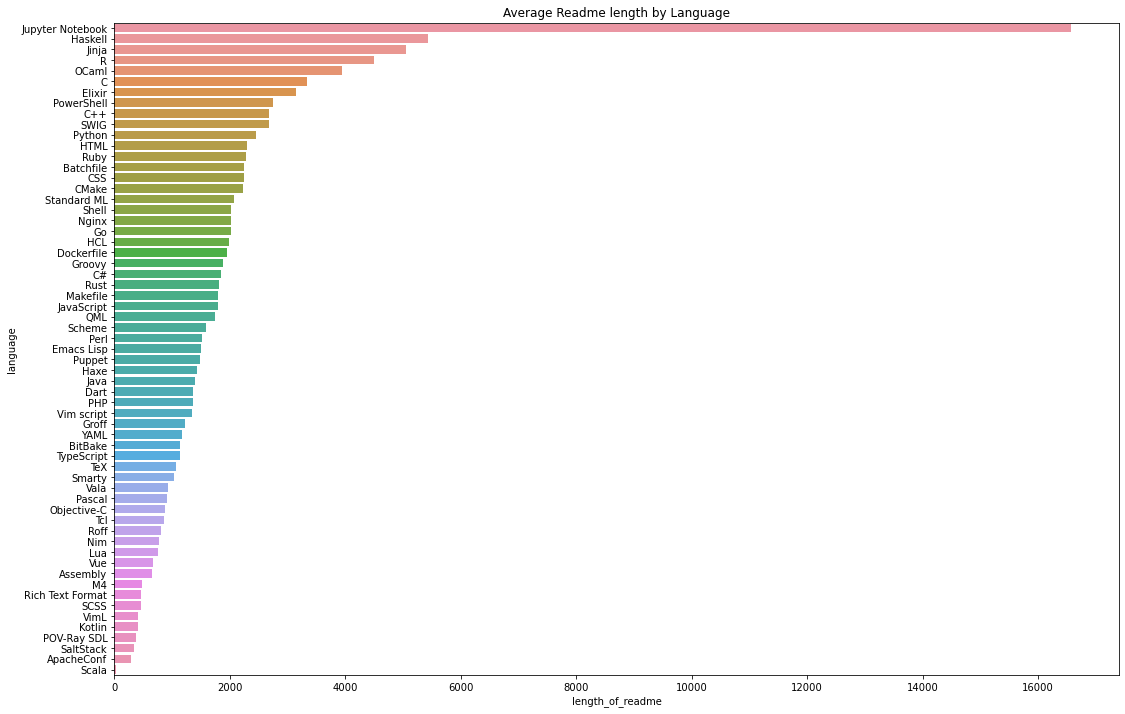

In [85]:
plt.figure(figsize=(18, 12))
sns.barplot(data = master_df.groupby('language').mean().reset_index().sort_values('length_of_readme', ascending=False), x = 'length_of_readme', y='language')
plt.title('Average Readme length by Language')
plt.show()

In [86]:
## Number of Unique words:
main_corpus_series = pd.Series(master_corpus_list)
pd.Series(master_corpus_list).nunique()

117986

### Most common bigrams:

In [87]:
master_bigrams = (pd.Series(nltk.ngrams(main_corpus_series, 2)).value_counts().head(20))
master_bigrams

(arch, linux)            1778
(3, 3)                   1096
(git, clone)              861
(aptget, install)         859
(sudo, aptget)            833
(sudo, apt)               812
(6, 6)                    744
(apt, install)            692
(make, sure)              691
(docker, run)             673
(math, kernel)            644
(kernel, library)         644
(intelr, math)            640
(3, 6)                    538
(accept, poster)          532
(6, 3)                    529
(ubuntu, server)          504
(configuration, file)     476
(bash, sudo)              462
(141, reject)             455
dtype: int64

In [88]:
##realized I forgot to rename my cleaned df...will need to go back up and find that...